In [1]:
from common import *

In [2]:
df_train = pd.read_csv(DATA_DIR+'/train.csv')

In [3]:
df_train.head()

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


In [4]:
df_train.label_group.nunique()

11014

In [5]:
df_train.label_group.value_counts()

994676122     51
159351600     51
562358068     51
3113678103    51
1163569239    51
              ..
3996065489     2
517023446      2
2101581536     2
3460538113     2
3927456083     2
Name: label_group, Length: 11014, dtype: int64

In [6]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
img = cv2.imread(DATA_DIR+'/train_images/0000a68812bc7e98c42888dfb1c07da0.jpg')
img.shape

(1024, 1024, 3)

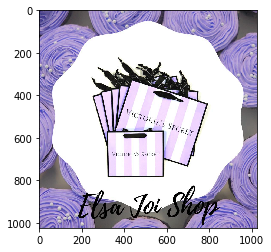

In [7]:
plt.imshow(img)

In [8]:
label_groups = list(set(list(df_train.label_group.values)))

In [9]:
len(label_groups)

11014

In [10]:
df = df_train.loc[df_train.label_group == label_groups[0]][['image', 'title']].reset_index(drop=True)
df.head()

,image,title
0,6e1346b2be9160b4ccb846e02abffb6b.jpg,Sarung Tangan Karet / Latex Freder (size M) Sa...
1,df05e92f362469ce88e1beca2818072c.jpg,SARUNG TANGAN KARET TEBAL BAGUS FREEDER CUCI P...
2,e185567c44955a66f873076d1c89ac11.jpg,SARUNG TANGAN KARET KENMASTER / FREEDER ORI100...


In [11]:
df.iloc[0].image

'6e1346b2be9160b4ccb846e02abffb6b.jpg'

3


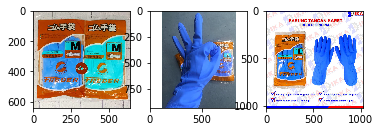

In [12]:
import matplotlib.pyplot as plt
import cv2

df = df_train.loc[df_train.label_group == label_groups[0]][['image']]
print(len(df))
columns = 4
rows = int(np.ceil(len(df)/columns))
w=10
h=10
fig=plt.figure(figsize=(8, 8))

dim = (h,w)
for i in range(1, columns*rows +1):
    try:
        img_file = DATA_DIR+'/train_images/' + df.iloc[i-1].image
        img = cv2.imread(img_file)
        resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
    except:
        continue
plt.show()

In [13]:
# for ii in range(1000):
#     df = df_train.loc[df_train.label_group == label_groups[ii]][['image']]
#     print(ii, len(df))
#     columns = 4
#     rows = int(np.ceil(len(df)/columns))
#     w=10
#     h=10
#     fig=plt.figure(figsize=(8, 8))

#     dim = (h,w)
#     for i in range(1, columns*rows +1):
#         try:
#             img_file = DATA_DIR+'/train_images/' + df.iloc[i-1].image
#             img = cv2.imread(img_file)
#             resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
#             fig.add_subplot(rows, columns, i)
#             plt.imshow(img)
#         except:
#             continue
#     plt.show()

In [50]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.model_selection import train_test_split
from skimage import exposure

from albumentations import (
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,    
    CenterCrop,    
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    RandomBrightnessContrast,    
    
    RandomGamma,
    ShiftScaleRotate ,
    GaussNoise,
    Blur,
    MotionBlur,   
    GaussianBlur,
)

import warnings
warnings.filterwarnings('ignore')
plt.ion()   # interactive mode

In [42]:
# # https://www.kaggle.com/iafoss/data-repack-and-image-statistics
def convert_images(filename, sz=256):
    filename = DATA_DIR+'/train_images/' + filename
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (sz, sz))
    #     img = exposure.equalize_adapthist(img)
    img = img/255.0

#     print(img.shape)
    x_tot = img.mean() #image statistics
    x2_tot = (img**2).mean()
    del img
    return x_tot, x2_tot

def get_stats(stats): # get dataset statistics 
    x_tot, x2_tot = 0.0, 0.0
    for x, x2 in stats:
        x_tot += x
        x2_tot += x2
    
    img_avr =  x_tot/len(stats)
    img_std =  np.sqrt(x2_tot/len(stats) - img_avr**2)
    print('mean:',img_avr, ', std:', img_std)

In [43]:
train_image_names = df_train['image'].values

In [44]:
# # https://www.kaggle.com/iafoss/data-repack-and-image-statistics
trn_stats = []
for fname in tqdm(train_image_names, total=len(train_image_names)):
    trn_stats.append(convert_images(fname))

# # test_stats = []        
# # with zipfile.ZipFile(test_out, 'w') as arch:
# #     for fname in tqdm(test, total=len(test)):
# #         test_stats.append(convert_images(fname,arch))

In [45]:
get_stats(trn_stats)

mean: 0.7138693191582812 , std: 0.3153962310202438


In [46]:
# dataset = datasets.ImageFolder(DATA_DIR+'/train_images')
# loader = torch.utils.data.DataLoader(dataset,
#                          batch_size=10,
#                          num_workers=0,
#                          shuffle=False)

# mean = 0.
# std = 0.
# for images, _ in loader:
#     batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
#     images = images.view(batch_samples, images.size(1), -1)
#     mean += images.mean(2).sum(0)
#     std += images.std(2).sum(0)

# mean /= len(loader.dataset)
# std /= len(loader.dataset)
# print(mean, std)

In [48]:
train_aug = Compose([ 
    ShiftScaleRotate(p=1,border_mode=cv2.BORDER_CONSTANT,value =1),
    OneOf([
        ElasticTransform(p=0.1, alpha=1, sigma=50, alpha_affine=50,border_mode=cv2.BORDER_CONSTANT,value =1),
        GridDistortion(distort_limit =0.05 ,border_mode=cv2.BORDER_CONSTANT,value =1, p=0.1),
        OpticalDistortion(p=0.1, distort_limit= 0.05, shift_limit=0.2,border_mode=cv2.BORDER_CONSTANT,value =1)                  
        ], p=0.3),
    OneOf([
        GaussNoise(var_limit=1.0),
        Blur(),
        GaussianBlur(blur_limit=3)
        ], p=0.4),    
    RandomGamma(p=0.8)])

In [51]:
class Normalize:
    def __init__(self, mean, std):
        self.mean = np.array(mean)
        self.std = np.array(std)

    def __call__(self, image):
        image = np.asarray(image).astype(np.float32) / 255.
        image = (image - self.mean) / self.std
        return image
    
## Create dataset function
class ShopeeDataset(Dataset):
    def __init__(self,df,_type='train',transform =True,aug=train_aug):
        self.df = df
        self.label = self.df[['label_group']].values
        self.aug = aug
        self.transform = transform
        self.data = df[['image']].values
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        label = self.label[idx]
        #image = self.df.iloc[idx][1:].values.reshape(128,128).astype(np.float)
        image = cv2.imread(self.data[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        dim = (256,256)
        image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
        
        if self.transform:
            augment = self.aug(image =image)
            image = augment['image']
#             cutout = Cutout(32,0.5,True,1)
#             image = cutout(image)
        norm = Normalize([0.7138693191582812],[0.3153962310202438])
        image = norm(image)

        return image,label


In [ ]:
train_df , valid_df = train_test_split(train,test_size=0.20, random_state=42,shuffle=True) 

In [15]:
# Data augmentation and normalization for training
# # Just normalization for validation
# data_transforms = {
#     'train': transforms.Compose([
# #         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'val': transforms.Compose([
#         transforms.Resize(256),
# #         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
# }

In [17]:
# X = df_train['image'].values
# y = df_train['label_group'].values

In [ ]:
# def train_val_dataset(dataset, val_split=0.2):
#     train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
#     datasets = {}
#     datasets['train'] = Subset(dataset, train_idx)
#     datasets['val'] = Subset(dataset, val_idx)
#     return datasets

In [ ]:
# dataset = ImageFolder('C:\Datasets\lcms-dataset', transform=Compose([Resize((224,224)),ToTensor()]))
# print(len(dataset))
# datasets = train_val_dataset(dataset)
# print(len(datasets['train']))
# print(len(datasets['val']))
# # The original dataset is available in the Subset class
# print(datasets['train'].dataset)

# dataloaders = {x:DataLoader(datasets[x],32, shuffle=True, num_workers=4) for x in ['train','val']}
# x,y = next(iter(dataloaders['train']))
# print(x.shape, y.shape)

In [21]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# ??train_test_split

In [ ]:
# data_dir = DATA_DIR
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
#                                           data_transforms[x])
#                   for x in ['train', 'val']}
# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
#                                              shuffle=True, num_workers=4)
#               for x in ['train', 'val']}
# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# class_names = image_datasets['train'].classes

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
## Mish Activation Function Not yet Used . May be later 
class Mish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x): 
        
        x = x *( torch.tanh(F.softplus(x)))

        return x

In [53]:
## Over9000 Optimizer . Inspired by Iafoss . Over and Out !
##https://github.com/mgrankin/over9000/blob/master/ralamb.py
import torch, math
from torch.optim.optimizer import Optimizer

# RAdam + LARS
class Ralamb(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(Ralamb, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Ralamb, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('Ralamb does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                # Decay the first and second moment running average coefficient
                # m_t
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                # v_t
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]

                if state['step'] == buffered[0]:
                    N_sma, radam_step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        radam_step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        radam_step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = radam_step_size
                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                radam_step = p_data_fp32.clone()
                if N_sma >= 5:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    radam_step.addcdiv_(-radam_step_size * group['lr'], exp_avg, denom)
                else:
                    radam_step.add_(-radam_step_size * group['lr'], exp_avg)

                radam_norm = radam_step.pow(2).sum().sqrt()
                weight_norm = p.data.pow(2).sum().sqrt().clamp(0, 10)
                if weight_norm == 0 or radam_norm == 0:
                    trust_ratio = 1
                else:
                    trust_ratio = weight_norm / radam_norm

                state['weight_norm'] = weight_norm
                state['adam_norm'] = radam_norm
                state['trust_ratio'] = trust_ratio

                if N_sma >= 5:
                    p_data_fp32.addcdiv_(-radam_step_size * group['lr'] * trust_ratio, exp_avg, denom)
                else:
                    p_data_fp32.add_(-radam_step_size * group['lr'] * trust_ratio, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss
# Lookahead implementation from https://github.com/rwightman/pytorch-image-models/blob/master/timm/optim/lookahead.py

""" Lookahead Optimizer Wrapper.
Implementation modified from: https://github.com/alphadl/lookahead.pytorch
Paper: `Lookahead Optimizer: k steps forward, 1 step back` - https://arxiv.org/abs/1907.08610
"""
import torch
from torch.optim.optimizer import Optimizer
from collections import defaultdict

class Lookahead(Optimizer):
    def __init__(self, base_optimizer, alpha=0.5, k=6):
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        defaults = dict(lookahead_alpha=alpha, lookahead_k=k, lookahead_step=0)
        self.base_optimizer = base_optimizer
        self.param_groups = self.base_optimizer.param_groups
        self.defaults = base_optimizer.defaults
        self.defaults.update(defaults)
        self.state = defaultdict(dict)
        # manually add our defaults to the param groups
        for name, default in defaults.items():
            for group in self.param_groups:
                group.setdefault(name, default)
    def update_slow(self, group):
        for fast_p in group["params"]:
            if fast_p.grad is None:
                continue
            param_state = self.state[fast_p]
            if 'slow_buffer' not in param_state:
                param_state['slow_buffer'] = torch.empty_like(fast_p.data)
                param_state['slow_buffer'].copy_(fast_p.data)
            slow = param_state['slow_buffer']
            slow.add_(group['lookahead_alpha'], fast_p.data - slow)
            fast_p.data.copy_(slow)

    def sync_lookahead(self):
        for group in self.param_groups:
            self.update_slow(group)

    def step(self, closure=None):
        # print(self.k)
        #assert id(self.param_groups) == id(self.base_optimizer.param_groups)
        loss = self.base_optimizer.step(closure)
        for group in self.param_groups:
            group['lookahead_step'] += 1
            if group['lookahead_step'] % group['lookahead_k'] == 0:
                self.update_slow(group)
        return loss
    def state_dict(self):
        fast_state_dict = self.base_optimizer.state_dict()
        slow_state = {
            (id(k) if isinstance(k, torch.Tensor) else k): v
            for k, v in self.state.items()
        }
        fast_state = fast_state_dict['state']
        param_groups = fast_state_dict['param_groups']
        return {
            'state': fast_state,
            'slow_state': slow_state,
            'param_groups': param_groups,
        }

    def load_state_dict(self, state_dict):
        fast_state_dict = {
            'state': state_dict['state'],
            'param_groups': state_dict['param_groups'],
        }
        self.base_optimizer.load_state_dict(fast_state_dict)

        # We want to restore the slow state, but share param_groups reference
        # with base_optimizer. This is a bit redundant but least code
        slow_state_new = False
        if 'slow_state' not in state_dict:
            print('Loading state_dict from optimizer without Lookahead applied.')
            state_dict['slow_state'] = defaultdict(dict)
            slow_state_new = True
        slow_state_dict = {
            'state': state_dict['slow_state'],
            'param_groups': state_dict['param_groups'],  # this is pointless but saves code
        }
        super(Lookahead, self).load_state_dict(slow_state_dict)
        self.param_groups = self.base_optimizer.param_groups  # make both ref same container
        if slow_state_new:
            # reapply defaults to catch missing lookahead specific ones
            for name, default in self.defaults.items():
                for group in self.param_groups:
                    group.setdefault(name, default)

def LookaheadAdam(params, alpha=0.5, k=6, *args, **kwargs):
    adam = Adam(params, *args, **kwargs)
    return Lookahead(adam, alpha, k)


# RAdam + LARS + LookAHead

# Lookahead implementation from https://github.com/lonePatient/lookahead_pytorch/blob/master/optimizer.py
# RAdam + LARS implementation from https://gist.github.com/redknightlois/c4023d393eb8f92bb44b2ab582d7ec20

def Over9000(params, alpha=0.5, k=6, *args, **kwargs):
    ralamb = Ralamb(params, *args, **kwargs)
    return Lookahead(ralamb, alpha, k)

RangerLars = Over9000 

In [63]:
## Code copied from Lukemelas github repository have a look
## https://github.com/lukemelas/EfficientNet-PyTorch/tree/master/efficientnet_pytorch
"""
This file contains helper functions for building the model and for loading model parameters.
These helper functions are built to mirror those in the official TensorFlow implementation.
"""

import re
import math
import collections
from functools import partial
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils import model_zoo

########################################################################
############### HELPERS FUNCTIONS FOR MODEL ARCHITECTURE ###############
########################################################################

# Parameters for the entire model (stem, all blocks, and head)
GlobalParams = collections.namedtuple('GlobalParams', [
    'batch_norm_momentum', 'batch_norm_epsilon', 'dropout_rate',
    'num_classes', 'width_coefficient', 'depth_coefficient',
    'depth_divisor', 'min_depth', 'drop_connect_rate', 'image_size'])

# Parameters for an individual model block
BlockArgs = collections.namedtuple('BlockArgs', [
    'kernel_size', 'num_repeat', 'input_filters', 'output_filters',
    'expand_ratio', 'id_skip', 'stride', 'se_ratio'])

# Change namedtuple defaults
GlobalParams.__new__.__defaults__ = (None,) * len(GlobalParams._fields)
BlockArgs.__new__.__defaults__ = (None,) * len(BlockArgs._fields)


class SwishImplementation(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * torch.sigmoid(i)
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_variables[0]
        sigmoid_i = torch.sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))


class MemoryEfficientSwish(nn.Module):
    def forward(self, x):
        return SwishImplementation.apply(x)

class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


def round_filters(filters, global_params):
    """ Calculate and round number of filters based on depth multiplier. """
    multiplier = global_params.width_coefficient
    if not multiplier:
        return filters
    divisor = global_params.depth_divisor
    min_depth = global_params.min_depth
    filters *= multiplier
    min_depth = min_depth or divisor
    new_filters = max(min_depth, int(filters + divisor / 2) // divisor * divisor)
    if new_filters < 0.9 * filters:  # prevent rounding by more than 10%
        new_filters += divisor
    return int(new_filters)


def round_repeats(repeats, global_params):
    """ Round number of filters based on depth multiplier. """
    multiplier = global_params.depth_coefficient
    if not multiplier:
        return repeats
    return int(math.ceil(multiplier * repeats))

def drop_connect(inputs, p, training):
    """ Drop connect. """
    if not training: return inputs
    batch_size = inputs.shape[0]
    keep_prob = 1 - p
    random_tensor = keep_prob
    random_tensor += torch.rand([batch_size, 1, 1, 1], dtype=inputs.dtype, device=inputs.device)
    binary_tensor = torch.floor(random_tensor)
    output = inputs / keep_prob * binary_tensor
    return output


def get_same_padding_conv2d(image_size=None):
    """ Chooses static padding if you have specified an image size, and dynamic padding otherwise.
        Static padding is necessary for ONNX exporting of models. """
    if image_size is None:
        return Conv2dDynamicSamePadding
    else:
        return partial(Conv2dStaticSamePadding, image_size=image_size)


class Conv2dDynamicSamePadding(nn.Conv2d):
    """ 2D Convolutions like TensorFlow, for a dynamic image size """

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1, groups=1, bias=True):
        super().__init__(in_channels, out_channels, kernel_size, stride, 0, dilation, groups, bias)
        self.stride = self.stride if len(self.stride) == 2 else [self.stride[0]] * 2

    def forward(self, x):
        ih, iw = x.size()[-2:]
        kh, kw = self.weight.size()[-2:]
        sh, sw = self.stride
        oh, ow = math.ceil(ih / sh), math.ceil(iw / sw)
        pad_h = max((oh - 1) * self.stride[0] + (kh - 1) * self.dilation[0] + 1 - ih, 0)
        pad_w = max((ow - 1) * self.stride[1] + (kw - 1) * self.dilation[1] + 1 - iw, 0)
        if pad_h > 0 or pad_w > 0:
            x = F.pad(x, [pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2])
        return F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)


class Conv2dStaticSamePadding(nn.Conv2d):
    """ 2D Convolutions like TensorFlow, for a fixed image size"""

    def __init__(self, in_channels, out_channels, kernel_size, image_size=None, **kwargs):
        super().__init__(in_channels, out_channels, kernel_size, **kwargs)
        self.stride = self.stride if len(self.stride) == 2 else [self.stride[0]] * 2

        # Calculate padding based on image size and save it
        assert image_size is not None
        ih, iw = image_size if type(image_size) == list else [image_size, image_size]
        kh, kw = self.weight.size()[-2:]
        sh, sw = self.stride
        oh, ow = math.ceil(ih / sh), math.ceil(iw / sw)
        pad_h = max((oh - 1) * self.stride[0] + (kh - 1) * self.dilation[0] + 1 - ih, 0)
        pad_w = max((ow - 1) * self.stride[1] + (kw - 1) * self.dilation[1] + 1 - iw, 0)
        if pad_h > 0 or pad_w > 0:
            self.static_padding = nn.ZeroPad2d((pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2))
        else:
            self.static_padding = Identity()

    def forward(self, x):
        x = self.static_padding(x)
        x = F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)
        return x


class Identity(nn.Module):
    def __init__(self, ):
        super(Identity, self).__init__()

    def forward(self, input):
        return input

    
########################################################################
############## HELPERS FUNCTIONS FOR LOADING MODEL PARAMS ##############
########################################################################


def efficientnet_params(model_name):
    """ Map EfficientNet model name to parameter coefficients. """
    params_dict = {
        # Coefficients:   width,depth,res,dropout
        'efficientnet-b0': (1.0, 1.0, 224, 0.2),
        'efficientnet-b1': (1.0, 1.1, 240, 0.2),
        'efficientnet-b2': (1.1, 1.2, 260, 0.3),
        'efficientnet-b3': (1.2, 1.4, 300, 0.3),
        'efficientnet-b4': (1.4, 1.8, 380, 0.4),
        'efficientnet-b5': (1.6, 2.2, 456, 0.4),
        'efficientnet-b6': (1.8, 2.6, 528, 0.5),
        'efficientnet-b7': (2.0, 3.1, 600, 0.5),
    }
    return params_dict[model_name]


class BlockDecoder(object):
    """ Block Decoder for readability, straight from the official TensorFlow repository """

    @staticmethod
    def _decode_block_string(block_string):
        """ Gets a block through a string notation of arguments. """
        assert isinstance(block_string, str)

        ops = block_string.split('_')
        options = {}
        for op in ops:
            splits = re.split(r'(\d.*)', op)
            if len(splits) >= 2:
                key, value = splits[:2]
                options[key] = value

        # Check stride
        assert (('s' in options and len(options['s']) == 1) or
                (len(options['s']) == 2 and options['s'][0] == options['s'][1]))

        return BlockArgs(
            kernel_size=int(options['k']),
            num_repeat=int(options['r']),
            input_filters=int(options['i']),
            output_filters=int(options['o']),
            expand_ratio=int(options['e']),
            id_skip=('noskip' not in block_string),
            se_ratio=float(options['se']) if 'se' in options else None,
            stride=[int(options['s'][0])])

    @staticmethod
    def _encode_block_string(block):
        """Encodes a block to a string."""
        args = [
            'r%d' % block.num_repeat,
            'k%d' % block.kernel_size,
            's%d%d' % (block.strides[0], block.strides[1]),
            'e%s' % block.expand_ratio,
            'i%d' % block.input_filters,
            'o%d' % block.output_filters
        ]
        if 0 < block.se_ratio <= 1:
            args.append('se%s' % block.se_ratio)
        if block.id_skip is False:
            args.append('noskip')
        return '_'.join(args)

    @staticmethod
    def decode(string_list):
        """
        Decodes a list of string notations to specify blocks inside the network.
        :param string_list: a list of strings, each string is a notation of block
        :return: a list of BlockArgs namedtuples of block args
        """
        assert isinstance(string_list, list)
        blocks_args = []
        for block_string in string_list:
            blocks_args.append(BlockDecoder._decode_block_string(block_string))
        return blocks_args
    @staticmethod
    def encode(blocks_args):
        """
        Encodes a list of BlockArgs to a list of strings.
        :param blocks_args: a list of BlockArgs namedtuples of block args
        :return: a list of strings, each string is a notation of block
        """
        block_strings = []
        for block in blocks_args:
            block_strings.append(BlockDecoder._encode_block_string(block))
        return block_strings

def efficientnet(width_coefficient=None, depth_coefficient=None, dropout_rate=0.2,
                 drop_connect_rate=0.2, image_size=None, num_classes=1000):
    """ Creates a efficientnet model. """

    blocks_args = [
        'r1_k3_s11_e1_i32_o16_se0.25', 'r2_k3_s22_e6_i16_o24_se0.25',
        'r2_k5_s22_e6_i24_o40_se0.25', 'r3_k3_s22_e6_i40_o80_se0.25',
        'r3_k5_s11_e6_i80_o112_se0.25', 'r4_k5_s22_e6_i112_o192_se0.25',
        'r1_k3_s11_e6_i192_o320_se0.25',
    ]
    blocks_args = BlockDecoder.decode(blocks_args)

    global_params = GlobalParams(
        batch_norm_momentum=0.99,
        batch_norm_epsilon=1e-3,
        dropout_rate=dropout_rate,
        drop_connect_rate=drop_connect_rate,
        # data_format='channels_last',  # removed, this is always true in PyTorch
        num_classes=num_classes,
        width_coefficient=width_coefficient,
        depth_coefficient=depth_coefficient,
        depth_divisor=8,
        min_depth=None,
        image_size=image_size,
    )

    return blocks_args, global_params

def get_model_params(model_name, override_params):
    """ Get the block args and global params for a given model """
    if model_name.startswith('efficientnet'):
        w, d, s, p = efficientnet_params(model_name)
        # note: all models have drop connect rate = 0.2
        blocks_args, global_params = efficientnet(
            width_coefficient=w, depth_coefficient=d, dropout_rate=p, image_size=s)
    else:
        raise NotImplementedError('model name is not pre-defined: %s' % model_name)
    if override_params:
        # ValueError will be raised here if override_params has fields not included in global_params.
        global_params = global_params._replace(**override_params)
    return blocks_args, global_params


url_map = {
#     'efficientnet-b0': '../input/efficientnet-pytorch/efficientnet-b0-08094119.pth',
    'efficientnet-b0': CACHE_DIR+'/efficientnet-b0-08094119.pth',
    'efficientnet-b1': CACHE_DIR+'/efficientnet-b1-f1951068.pth',
    'efficientnet-b2': CACHE_DIR+'/efficientnet-b2-8bb594d6.pth',
    'efficientnet-b3': CACHE_DIR+'/efficientnet-b3-5fb5a3c3.pth',
    'efficientnet-b4': CACHE_DIR+'/efficientnet-b4-6ed6700e.pth',
    'efficientnet-b5': CACHE_DIR+'/efficientnet-b5-b6417697.pth',
    'efficientnet-b6': CACHE_DIR+'/efficientnet-b6-c76e70fd.pth',
    'efficientnet-b7': CACHE_DIR+'/efficientnet-b7-dcc49843.pth',
}

## This below function is modified to use the pretrained weight for single channel . Its nothing but summing the weight across one axis .
def load_pretrained_weights(model, model_name, load_fc=True,ch=1):
    """ Loads pretrained weights, and downloads if loading for the first time. """
    state_dict = torch.load(CACHE_DIR+'/efficientnet-b0-08094119.pth')
    if load_fc:
        if ch == 1:
            conv1_weight = state_dict['_conv_stem.weight']
            state_dict['_conv_stem.weight'] = conv1_weight.sum(dim=1, keepdim=True)
        model.load_state_dict(state_dict)
        
    else:
        state_dict.pop('_fc.weight')
        state_dict.pop('_fc.bias')
        if ch == 1:
            conv1_weight = state_dict['_conv_stem.weight']
            state_dict['_conv_stem.weight'] = conv1_weight.sum(dim=1, keepdim=True)
        res = model.load_state_dict(state_dict, strict=False)
        print(res.missing_keys)
        assert set(res.missing_keys) == set(['_fc.weight', '_fc.bias','fc1.weight', 'fc1.bias','fc2.weight', 'fc2.bias','fc3.weight', 'fc3.bias']), 'issue loading pretrained weights'
    print('Loaded pretrained weights for {}'.format(model_name))

In [64]:
import torch
from torch import nn
from torch.nn import functional as F


class MBConvBlock(nn.Module):
    """
    Mobile Inverted Residual Bottleneck Block
    Args:
        block_args (namedtuple): BlockArgs, see above
        global_params (namedtuple): GlobalParam, see above
    Attributes:
        has_se (bool): Whether the block contains a Squeeze and Excitation layer.
    """

    def __init__(self, block_args, global_params):
        super().__init__()
        self._block_args = block_args
        self._bn_mom = 1 - global_params.batch_norm_momentum
        self._bn_eps = global_params.batch_norm_epsilon
        self.has_se = (self._block_args.se_ratio is not None) and (0 < self._block_args.se_ratio <= 1)
        self.id_skip = block_args.id_skip  # skip connection and drop connect

        # Get static or dynamic convolution depending on image size
        Conv2d = get_same_padding_conv2d(image_size=global_params.image_size)
        # Expansion phase
        inp = self._block_args.input_filters  # number of input channels
        oup = self._block_args.input_filters * self._block_args.expand_ratio  # number of output channels
        if self._block_args.expand_ratio != 1:
            self._expand_conv = Conv2d(in_channels=inp, out_channels=oup, kernel_size=1, bias=False)
            self._bn0 = nn.BatchNorm2d(num_features=oup, momentum=self._bn_mom, eps=self._bn_eps)

        # Depthwise convolution phase
        k = self._block_args.kernel_size
        s = self._block_args.stride
        self._depthwise_conv = Conv2d(
            in_channels=oup, out_channels=oup, groups=oup,  # groups makes it depthwise
            kernel_size=k, stride=s, bias=False)
        self._bn1 = nn.BatchNorm2d(num_features=oup, momentum=self._bn_mom, eps=self._bn_eps)

        # Squeeze and Excitation layer, if desired
        if self.has_se:
            num_squeezed_channels = max(1, int(self._block_args.input_filters * self._block_args.se_ratio))
            self._se_reduce = Conv2d(in_channels=oup, out_channels=num_squeezed_channels, kernel_size=1)
            self._se_expand = Conv2d(in_channels=num_squeezed_channels, out_channels=oup, kernel_size=1)
        # Output phase
        final_oup = self._block_args.output_filters
        self._project_conv = Conv2d(in_channels=oup, out_channels=final_oup, kernel_size=1, bias=False)
        self._bn2 = nn.BatchNorm2d(num_features=final_oup, momentum=self._bn_mom, eps=self._bn_eps)
        self._swish = MemoryEfficientSwish()

    def forward(self, inputs, drop_connect_rate=None):
        """
        :param inputs: input tensor
        :param drop_connect_rate: drop connect rate (float, between 0 and 1)
        :return: output of block
        """

        # Expansion and Depthwise Convolution
        x = inputs
        if self._block_args.expand_ratio != 1:
            x = self._swish(self._bn0(self._expand_conv(inputs)))
        x = self._swish(self._bn1(self._depthwise_conv(x)))

        # Squeeze and Excitation
        if self.has_se:
            x_squeezed = F.adaptive_avg_pool2d(x, 1)
            x_squeezed = self._se_expand(self._swish(self._se_reduce(x_squeezed)))
            x = torch.sigmoid(x_squeezed) * x

        x = self._bn2(self._project_conv(x))
        # Skip connection and drop connect
        input_filters, output_filters = self._block_args.input_filters, self._block_args.output_filters
        if self.id_skip and self._block_args.stride == 1 and input_filters == output_filters:
            if drop_connect_rate:
                x = drop_connect(x, p=drop_connect_rate, training=self.training)
            x = x + inputs  # skip connection
        return x

    def set_swish(self, memory_efficient=True):
        """Sets swish function as memory efficient (for training) or standard (for export)"""
        self._swish = MemoryEfficientSwish() if memory_efficient else Swish()


class EfficientNet(nn.Module):
    """
    An EfficientNet model. Most easily loaded with the .from_name or .from_pretrained methods
    Args:
        blocks_args (list): A list of BlockArgs to construct blocks
        global_params (namedtuple): A set of GlobalParams shared between blocks
    Example:
        model = EfficientNet.from_pretrained('efficientnet-b0')
    """

    def __init__(self, blocks_args=None, global_params=None):
        super().__init__()
        assert isinstance(blocks_args, list), 'blocks_args should be a list'
        assert len(blocks_args) > 0, 'block args must be greater than 0'
        self._global_params = global_params
        self._blocks_args = blocks_args

        # Get static or dynamic convolution depending on image size
        Conv2d = get_same_padding_conv2d(image_size=global_params.image_size)
        # Batch norm parameters
        bn_mom = 1 - self._global_params.batch_norm_momentum
        bn_eps = self._global_params.batch_norm_epsilon

        # Stem
        in_channels = 1  # rgb
        out_channels = round_filters(32, self._global_params)  # number of output channels
        self._conv_stem = Conv2d(in_channels, out_channels, kernel_size=3, stride=2, bias=False)
        self._bn0 = nn.BatchNorm2d(num_features=out_channels, momentum=bn_mom, eps=bn_eps)

        # Build blocks
        self._blocks = nn.ModuleList([])
        for block_args in self._blocks_args:

            # Update block input and output filters based on depth multiplier.
            block_args = block_args._replace(
                input_filters=round_filters(block_args.input_filters, self._global_params),
                output_filters=round_filters(block_args.output_filters, self._global_params),
                num_repeat=round_repeats(block_args.num_repeat, self._global_params)
            )

            # The first block needs to take care of stride and filter size increase.
            self._blocks.append(MBConvBlock(block_args, self._global_params))
            if block_args.num_repeat > 1:
                block_args = block_args._replace(input_filters=block_args.output_filters, stride=1)
            for _ in range(block_args.num_repeat - 1):
                self._blocks.append(MBConvBlock(block_args, self._global_params))
        # Head
        in_channels = block_args.output_filters  # output of final block
        out_channels = round_filters(1280, self._global_params)
        self._conv_head = Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self._bn1 = nn.BatchNorm2d(num_features=out_channels, momentum=bn_mom, eps=bn_eps)

        # Final linear layer
        self._avg_pooling = nn.AdaptiveAvgPool2d(1)
        self._dropout = nn.Dropout(self._global_params.dropout_rate)
        self._fc = nn.Linear(out_channels, self._global_params.num_classes)
        # vowel_diacritic
        self.fc1 = nn.Linear(out_channels,11)
        # grapheme_root
        self.fc2 = nn.Linear(out_channels,20)
        # consonant_diacritic
        self.fc3 = nn.Linear(out_channels,4)
        self._swish = MemoryEfficientSwish()

    def set_swish(self, memory_efficient=True):
        """Sets swish function as memory efficient (for training) or standard (for export)"""
        self._swish = MemoryEfficientSwish() if memory_efficient else Swish()
        for block in self._blocks:
            block.set_swish(memory_efficient)

    def extract_features(self, inputs):
        """ Returns output of the final convolution layer """

        # Stem
        x = self._swish(self._bn0(self._conv_stem(inputs)))

        # Blocks
        for idx, block in enumerate(self._blocks):
            drop_connect_rate = self._global_params.drop_connect_rate
            if drop_connect_rate:
                drop_connect_rate *= float(idx) / len(self._blocks)
            x = block(x, drop_connect_rate=drop_connect_rate)

        # Head
        x = self._swish(self._bn1(self._conv_head(x)))

        return x
    def forward(self, inputs):
        """ Calls extract_features to extract features, applies final linear layer, and returns logits. """
        bs = inputs.size(0)
        # Convolution layers
        x = self.extract_features(inputs)

        # Pooling and final linear layer
        x = self._avg_pooling(x)
        x = x.view(bs, -1)
        x = self._dropout(x)
       # x = self._fc(x)
        x1 = self.fc1(x)
        x2= self.fc2(x)
        x3 = self.fc3(x)
        return x1,x2,x3

    @classmethod
    def from_name(cls, model_name, override_params=None):
        cls._check_model_name_is_valid(model_name)
        blocks_args, global_params = get_model_params(model_name, override_params)
        return cls(blocks_args, global_params)

    @classmethod
    def from_pretrained(cls, model_name, num_classes=1000, in_channels = 1):
        model = cls.from_name(model_name, override_params={'num_classes': num_classes})
        load_pretrained_weights(model, model_name, load_fc=False)
        if in_channels != 3:
            Conv2d = get_same_padding_conv2d(image_size = model._global_params.image_size)
            out_channels = round_filters(32, model._global_params)
            model._conv_stem = Conv2d(in_channels, out_channels, kernel_size=3, stride=2, bias=False)
        return model

    @classmethod
    def from_pretrained(cls, model_name, num_classes=1000):
        model = cls.from_name(model_name, override_params={'num_classes': num_classes})
        load_pretrained_weights(model, model_name, load_fc=False)

        return model

    @classmethod
    def get_image_size(cls, model_name):
        cls._check_model_name_is_valid(model_name)
        _, _, res, _ = efficientnet_params(model_name)
        return res

    @classmethod
    def _check_model_name_is_valid(cls, model_name, also_need_pretrained_weights=False):
        """ Validates model name. None that pretrained weights are only available for
        the first four models (efficientnet-b{i} for i in 0,1,2,3) at the moment. """
        num_models = 4 if also_need_pretrained_weights else 8
        valid_models = ['efficientnet-b'+str(i) for i in range(num_models)]
        if model_name not in valid_models:
            raise ValueError('model_name should be one of: ' + ', '.join(valid_models))
            

In [65]:
## Make sure we are using the GPU . Get CUDA device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [66]:
## Now create the model. Since its greyscale , I have  used pretrained model with modified weight. 
##I will make the necessary modification to load pretrained weights for greyscale by summing up the weights over one axis or copying greyscale into three channels
model = EfficientNet.from_pretrained('efficientnet-b0').to(device) ## I switched to effnet-b4 in this version 

['_fc.weight', '_fc.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias']
Loaded pretrained weights for efficientnet-b0


In [68]:
## A Small but useful test of the Model by using dummy input . .
x = torch.zeros((32,1, 256, 256))
with torch.no_grad():
    output1,output2,output3 =model(x.to(device))
print(output3.shape)

torch.Size([32, 4])
